<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese_ORL(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [26]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
process = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4417, std=0.1958),
])

# dataset = list(att_dataset)
# torch.cat(dataset).mean() , torch.cat(dataset).std()
# #  (tensor(0.4417), tensor(0.1958))

In [7]:
att_dataset = CustomDataset(PATH, transform=process)

100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


In [8]:
att_dataset[0][0].shape

torch.Size([1, 224, 224])

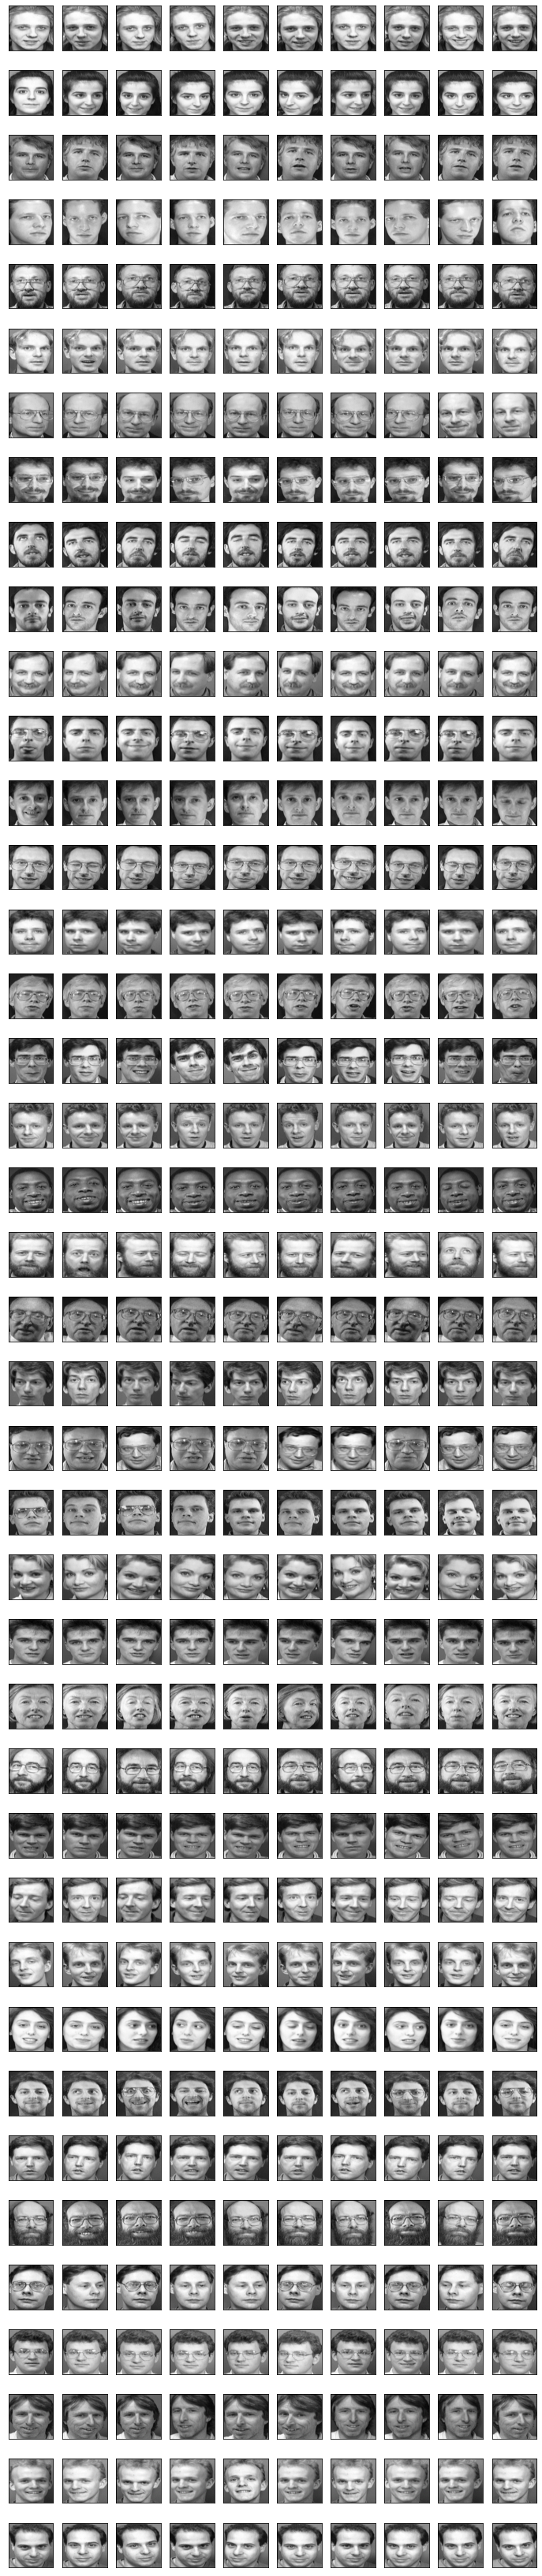

In [9]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [10]:
dataset = list(att_dataset)
torch.cat(dataset).mean() , torch.cat(dataset).std()
#  (tensor(0.4417), tensor(0.1958))

(tensor(0.0025), tensor(0.9860))

In [11]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [12]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [13]:
train = dataset[0:30]

In [14]:
len(train)

30

In [15]:
test = dataset[30:]

In [16]:
len(test)

10

In [17]:
class IdentityBlock(nn.Module):

    def __init__(self, n :int):
        super(IdentityBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n)

    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# Ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L37

In [18]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, n_in :int = None, n_out :int = None):
        super(ConvolutionalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        self.downsample = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2, padding=0, bias=False)),
            ('bn', nn.BatchNorm2d(num_features=n_out))
        ]))


    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# From the paper we can see that there are 2 options for matching the output size. Either padding the input volume or perform 1x1 convolutions. 
# Ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [19]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(OrderedDict([
            ('block1', IdentityBlock(n = 64)),
            ('block2', IdentityBlock(n = 64))
        ]))
                            
        self.layer2 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 64, n_out = 128)),
            ('block2', IdentityBlock(n = 128))
        ]))

        self.layer3 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 128, n_out = 256)),
            ('block2', IdentityBlock(n = 256))
        ]))
                            
        self.layer4 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 256, n_out = 512)),
            ('block2', IdentityBlock(n = 512))
        ]))
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512*1, out_features=128)
        # self.fc = nn.Linear(in_features=512*1, out_features=1000)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [55]:
resnet18 = ResNet18()
resnet18

ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): IdentityBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): IdentityBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [21]:
t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.conv1(t)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])


In [22]:
t = torch.rand(10,3,1,224,224)
print('rand', t.shape)
t = resnet18(t)
print('resnet18', t[0].shape, t[1].shape, t[2].shape)

rand torch.Size([10, 3, 1, 224, 224])
resnet18 torch.Size([10, 128]) torch.Size([10, 128]) torch.Size([10, 128])


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [24]:
count_parameters(resnet18)

11235904

In [57]:
learning_rate = 0.0001
optimizer = optim.Adam(resnet18.parameters(), lr = learning_rate)
if torch.cuda.is_available():
    resnet18 = resnet18.cuda()

In [59]:
cost = []
train_acc = []
test_acc = []
epochs = 20
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=100)
    for i,batch in enumerate(loader):
        if torch.cuda.is_available():
            apn = resnet18(batch.cuda())
        else:
            apn = resnet18(batch)

        optimizer.zero_grad()
        loss = triplet_loss(*apn)
        # loss = lossfn(*apn)
        cost.append(loss.item())

        loss.backward()
        optimizer.step()

        ####
        # sample = torch.cat([resnet18.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in range(40)])
        # total_enc = [resnet18.semi_forward(img.cuda()) for img in dataset]
        # pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
        # acc1 = sum([(pred[i] == i).sum() for i in range(0,30)]) / 300
        # acc2 = sum([(pred[i] == i).sum() for i in range(30,40)]) / 100
        # train_acc.append(acc1)
        # test_acc.append(acc2)
        ####

        if i%10==0 :
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss.item(), acc1, acc2))
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87] Cost : {loss.item()}')

Epoch:[1/20], Step:[1/87] Cost : 0.07158297300338745
Epoch:[1/20], Step:[11/87] Cost : 0.02684839442372322
Epoch:[1/20], Step:[21/87] Cost : 0.024341199547052383
Epoch:[1/20], Step:[31/87] Cost : 0.016789328306913376
Epoch:[1/20], Step:[41/87] Cost : 0.0
Epoch:[1/20], Step:[51/87] Cost : 0.009100460447371006
Epoch:[1/20], Step:[61/87] Cost : 0.03783904388546944
Epoch:[1/20], Step:[71/87] Cost : 0.015512577258050442
Epoch:[1/20], Step:[81/87] Cost : 0.0019692506175488234
Epoch:[2/20], Step:[1/87] Cost : 0.008968940936028957
Epoch:[2/20], Step:[11/87] Cost : 0.3632891774177551
Epoch:[2/20], Step:[21/87] Cost : 0.0004654522053897381
Epoch:[2/20], Step:[31/87] Cost : 0.0007778389845043421
Epoch:[2/20], Step:[41/87] Cost : 0.0
Epoch:[2/20], Step:[51/87] Cost : 0.003303092671558261
Epoch:[2/20], Step:[61/87] Cost : 0.0
Epoch:[2/20], Step:[71/87] Cost : 0.0015595827717334032
Epoch:[2/20], Step:[81/87] Cost : 0.3339884877204895
Epoch:[3/20], Step:[1/87] Cost : 0.0007642288110218942
Epoch:[3/20

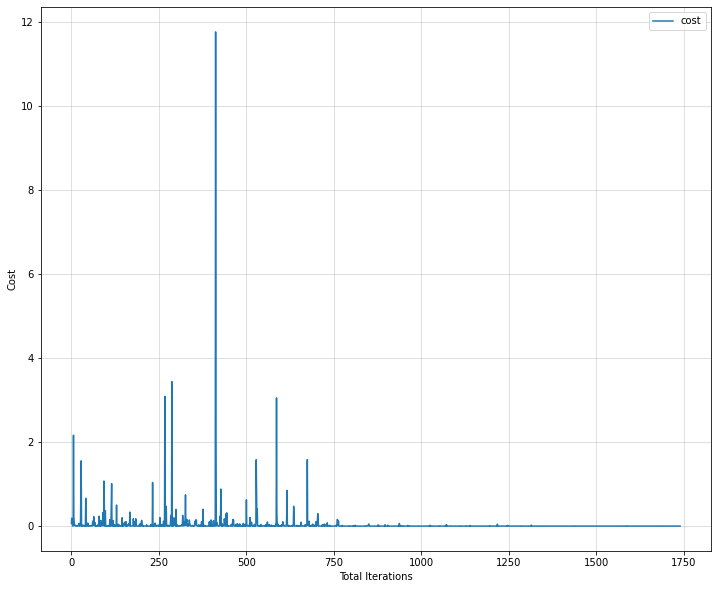

In [95]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost, label='cost')
# plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
# plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes')
plt.show()

In [96]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
n = (apn[0] - apn[2]).pow(2).sum(-1)

In [97]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(1.0119, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.6413, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(10.1432, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(4.4065, device='cuda:0', grad_fn=<MeanBackward0>))

In [31]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [75]:
sample = torch.cat([resnet18.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()).cpu() for i in tqdm(range(40))])



  0%|          | 0/40 [00:00<?, ?it/s]

 30%|███       | 12/40 [00:00<00:00, 110.72it/s]

 55%|█████▌    | 22/40 [00:00<00:00, 104.99it/s]

100%|██████████| 40/40 [00:00<00:00, 101.53it/s]


In [76]:
sample.shape

torch.Size([40, 128])

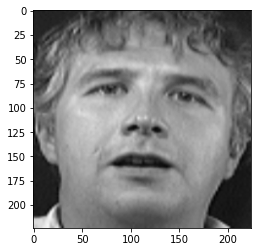

In [90]:
Class = 2
randImg = att_dataset[Class][5]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = resnet18.semi_forward(randImg.unsqueeze(0).cuda()).cpu()

In [91]:
dis = dist(renc, sample)
dis.argmin()

tensor(31)

In [82]:
del total_enc

In [83]:
total_enc = [resnet18.semi_forward(img.cuda()).cpu() for img in tqdm(dataset)]





  0%|          | 0/40 [00:00<?, ?it/s]



 35%|███▌      | 14/40 [00:00<00:00, 138.14it/s]



100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


In [80]:
torch.cuda.empty_cache()

In [68]:
total_enc[0].shape

torch.Size([10, 128])

In [84]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

tensor([ 0, 19, 25, 15, 10, 26, 15, 26, 28, 19])
tensor([ 1, 17,  4, 33,  5, 39, 17, 32, 32,  1])
tensor([ 2,  8,  1,  0,  2,  7,  5, 29, 12, 32])
tensor([ 3, 19,  3, 13, 22, 15,  1,  2,  7,  3])
tensor([ 4, 38, 34, 18,  8, 34, 24,  4, 24, 23])
tensor([ 5,  5, 30, 30,  5, 27,  6, 19, 24, 39])
tensor([ 6,  6, 11,  6, 20, 30, 33, 24, 24, 24])
tensor([ 7,  7, 17,  5, 23, 39, 17, 39, 23, 25])
tensor([ 8, 10,  1,  5,  8, 27, 29, 35, 12, 39])
tensor([ 8, 15,  8,  5,  9, 26, 15,  9, 34, 37])
tensor([10, 24, 36, 10, 34, 10, 37, 26, 10,  2])
tensor([11, 26, 11, 18, 11, 35, 17, 11, 29, 26])
tensor([12, 25, 12, 17, 39,  0,  5, 12, 12, 23])
tensor([13, 11, 26, 18, 13, 13, 34, 13, 39,  9])
tensor([14, 14, 14, 28, 36, 39, 32, 28, 14,  2])
tensor([15,  8, 26,  0, 26, 34,  4, 26, 15, 31])
tensor([16, 17, 17, 21, 16, 23, 25, 15, 16, 14])
tensor([17, 17, 29, 16, 35, 17, 28, 17, 39, 37])
tensor([18,  5, 15, 35, 29, 24, 18, 18, 18,  4])
tensor([19, 19, 34, 19, 39, 39, 38, 19, 19,  6])
tensor([20,  9, 15, 

In [85]:
sum([(pred[i] == i).sum() for i in range(0,30)]) / 300

tensor(0.2933)

In [86]:
tc = []
for i in range(0,40):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    tc.append(corr.item())

print('Train Accuracy = ', sum(tc[:30])/3, '%')
print('Test Accuracy = ', sum(tc[30:])/1, '%')
print('Total Accuracy = ', sum(tc)/4, '%')

#@markdown  | Parameter         |       Value        |
#@markdown  | ----------------- |:------------------:|
#@markdown  | Training Set      |  75% (300/400)     |
#@markdown  | Testing Set       |    25% (100/400)   |
#@markdown  | Validation Set    |    0% (0/400)      |
#@markdown  | Number of Epochs  |         16         |
#@markdown  | Learning Rate     |   10<sup>-4</sup>  |
#@markdown  | Total Parameters  |       4170400      |
#@markdown  | Loss Function     |    Triplet Loss    |
#@markdown  | Optimizer         |       Adam         |
#@markdown  |                   |                    |
#@markdown  | Train Accuracy    |      93.0 %        |
#@markdown  | Test Accuracy     |      73.0 %        |
#@markdown  | Total Accuracy    |      88.0 %        |


(Claas 0) 1 out of 10
(Claas 1) 2 out of 10
(Claas 2) 2 out of 10
(Claas 3) 3 out of 10
(Claas 4) 2 out of 10
(Claas 5) 3 out of 10
(Claas 6) 3 out of 10
(Claas 7) 2 out of 10
(Claas 8) 2 out of 10
(Claas 9) 2 out of 10
(Claas 10) 4 out of 10
(Claas 11) 4 out of 10
(Claas 12) 4 out of 10
(Claas 13) 4 out of 10
(Claas 14) 4 out of 10
(Claas 15) 2 out of 10
(Claas 16) 3 out of 10
(Claas 17) 4 out of 10
(Claas 18) 4 out of 10
(Claas 19) 5 out of 10
(Claas 20) 3 out of 10
(Claas 21) 1 out of 10
(Claas 22) 2 out of 10
(Claas 23) 2 out of 10
(Claas 24) 1 out of 10
(Claas 25) 6 out of 10
(Claas 26) 4 out of 10
(Claas 27) 4 out of 10
(Claas 28) 3 out of 10
(Claas 29) 2 out of 10
(Claas 30) 1 out of 10
(Claas 31) 3 out of 10
(Claas 32) 6 out of 10
(Claas 33) 2 out of 10
(Claas 34) 1 out of 10
(Claas 35) 4 out of 10
(Claas 36) 4 out of 10
(Claas 37) 1 out of 10
(Claas 38) 1 out of 10
(Claas 39) 3 out of 10
Train Accuracy =  29.333333333333332 %
Test Accuracy =  26.0 %
Total Accuracy =  28.5 %


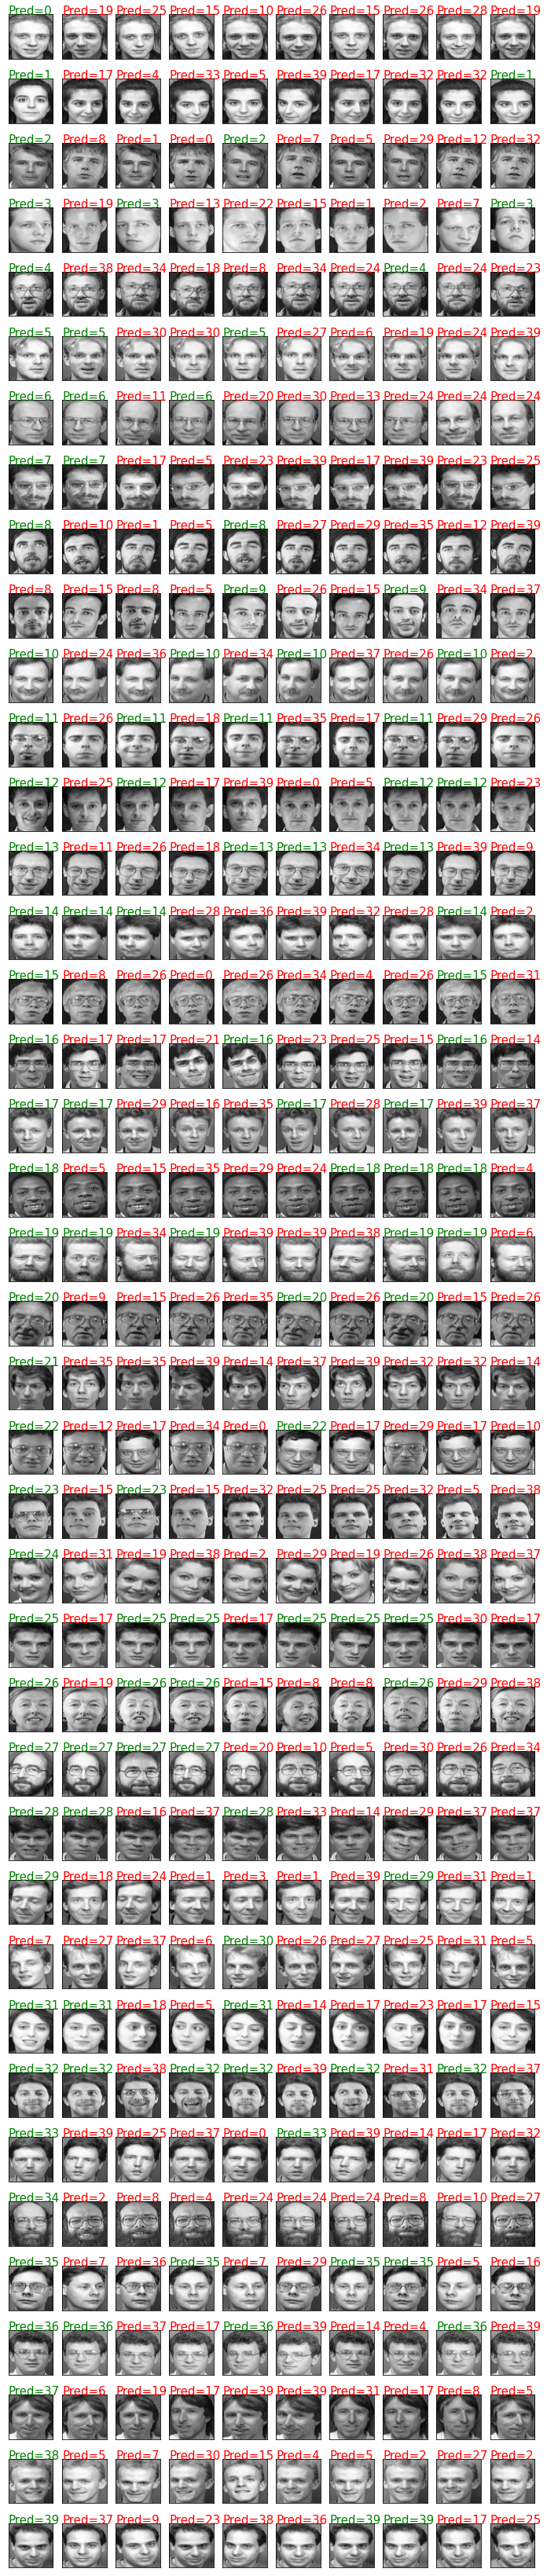

In [87]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes.png', dpi=200)
plt.show()

In [61]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese-orl(resnet)'

In [62]:
torch.save(resnet18.state_dict(), PATH)

In [ ]:
resnet18.load_state_dict(torch.load(PATH))
resnet18.eval()

In [ ]:
_,axxr = plt.subplots(10,10, figsize=(12,16))
for i in range(10):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i+10][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i+10}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()+10}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results.png', dpi=200)
plt.show()